In [1]:
#This is the flat field dictionary creator.
#it must be run before the pipeline is run since we need the flatDict var
#do not run create_flat_dict_file unless you have added a new flat field to the flats folder
import pickle
import pprint
from pipeline import create_flat_dict_file

#computer specific directories
homePath = '/home/agoga/Documents/nreshk/'
dataPath =homePath + 'data/'
outputPath = homePath + 'output/'
flatPath = dataPath + 'flats/'
flatPickle = "flatDict.pkl"

#UNCOMMENT TO RECREATE THE FLAT DICTIONARY
#create_flat_dict_file(flatPath,flatPickle)

f = open(flatPath+flatPickle,"rb")
flatDict = pickle.load(f)
f.close()


#pprint.pprint(flatDict)

In [2]:
#loading the reference spectra is a long process so we don't want to do it much
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra

#need this in memory for the following wrapper
lab = import_lab_frame_spectra(dataPath+ 'LabSpectra/', resolution=0)#,res*10)

bad folder 'new'
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 114710
-------------------------------------------------------------------------------
MJD: 58511.3564135 and decYr 2019.0749490780822 w/ shk: 0.196612138585779 and offset:0.12398084935317137
bad correlation: 1.0536445242853076
-------------------------------------------------------------------------------
MJD: 58336.1378987 and decYr 2018.5948983526027 w/ shk: 0.1523345892204775 and offset:0.17079623633746568
bad correlation: 1.0982385512471
-------------------------------------------------------------------------------
MJD: 58103.4311035 and decYr 2017.957345489041 w/ shk: 0.08554894811257499 and offset:0.09348679209894849
bad correlation: 1.2290819099724388
-------------------------------------------------------------------------------
>f8
MJD: 58243.2473286 and decYr 2018.34040364 w/ shk: 0.19815067678095005 and offset:0.10845448342262733
bad correlation: 1.1024915

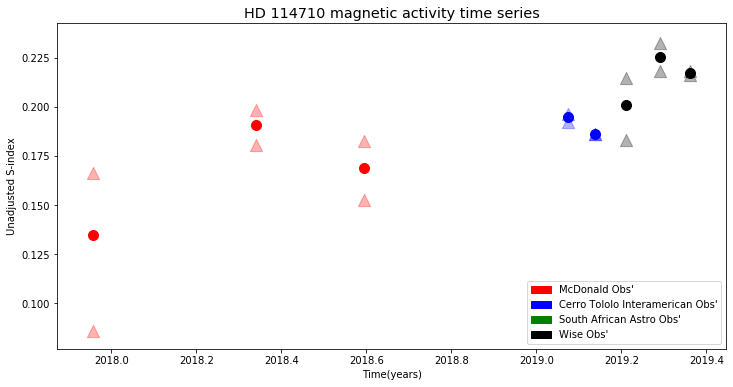

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 115404
-------------------------------------------------------------------------------
>f8
MJD: 58175.248315 and decYr 2018.1541049726027 w/ shk: 0.3591982811480074 and offset:0.10630358974295642
bad correlation: 1.5472098344599563
-------------------------------------------------------------------------------
MJD: 58126.3872534 and decYr 2018.020239050411 w/ shk: 0.5175191324202452 and offset:0.09787273806008062
bad correlation: 1.74900970120432
-------------------------------------------------------------------------------
MJD: 58563.9382095 and decYr 2019.2190087931506 w/ shk: 0.4500901263566687 and offset:0.1382934935661982
bad correlation: 1.2097294446968858
-------------------------------------------------------------------------------
MJD: 58272.0200237 and decYr 2018.419232941644 w/ shk: 0.39956640613438227 and offset:0.1838152853309046
bad correlation: 2.1167443989878194
bad: 

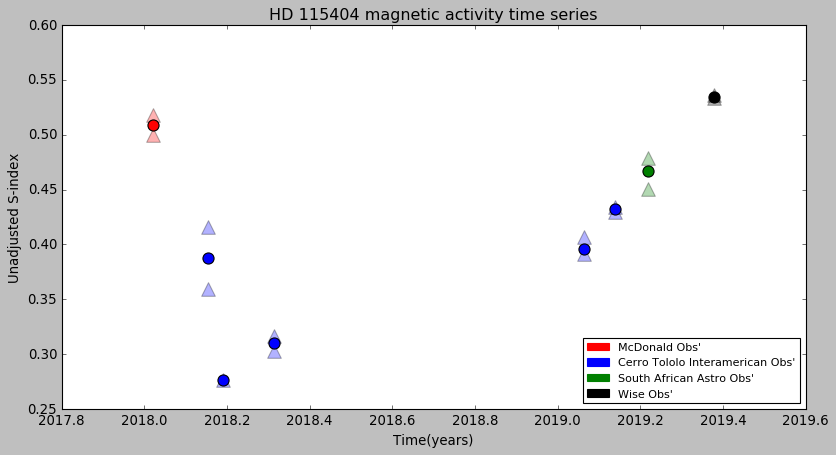

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 126053
-------------------------------------------------------------------------------
>f8
MJD: 58173.2465139 and decYr 2018.1486205860274 w/ shk: 0.061428606984543485 and offset:0.05842933824842552
bad correlation: 1.274716896624384
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58355.9805147 and decYr 2018.6492616841097 w/ shk: 0.15117902472785535 and offset:0.0916549683491912
bad correlation: 1.0879398752093123
bad: 58355.9805147
-------------------------------------------------------------------------------
MJD: 58271.0227829 and decYr 2018.4165007750685 w/ shk: 0.00746813588831871 and offset:0.1389555591066775
bad correlation: 1.4943457022773068
-------------------------------------------------------------------------------
MJD: 58558.0887142 and decYr 2019.20298277863 w/ shk: 0.16897202469740638 and offset:0.0

MJD: 58233.091783 and decYr 2018.3125802273973 w/ shk: -0.022158136919077906 and offset:0.09306647839558016
bad correlation: 1.4467409190997162
bad: 58233.091783


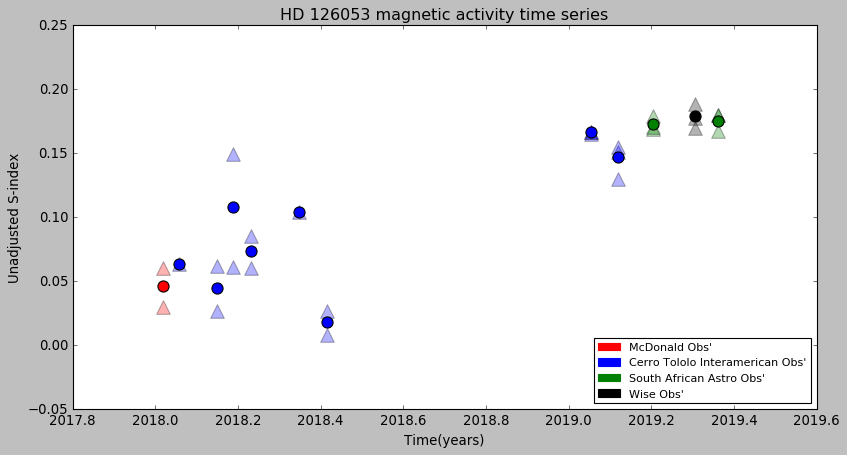

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 149661
-------------------------------------------------------------------------------
MJD: 58600.8640072 and decYr 2019.3201753621918 w/ shk: 0.29743633675045883 and offset:0.10798134632974186
bad correlation: 1.0851390660530826
-------------------------------------------------------------------------------
MJD: 58384.7427607 and decYr 2018.7280623580823 w/ shk: 0.3119070964399789 and offset:0.13217214475277572
bad correlation: 1.1188997270787824
-------------------------------------------------------------------------------
>f8
MJD: 58227.1720878 and decYr 2018.2963618843835 w/ shk: 0.1369077565999188 and offset:0.07397603787885293
bad correlation: 1.4071494371327002
-------------------------------------------------------------------------------
>f8
MJD: 58236.1871875 and decYr 2018.3210607876713 w/ shk: 0.2287391236710989 and offset:0.08275331777864123
bad correlation: 1.22359150593

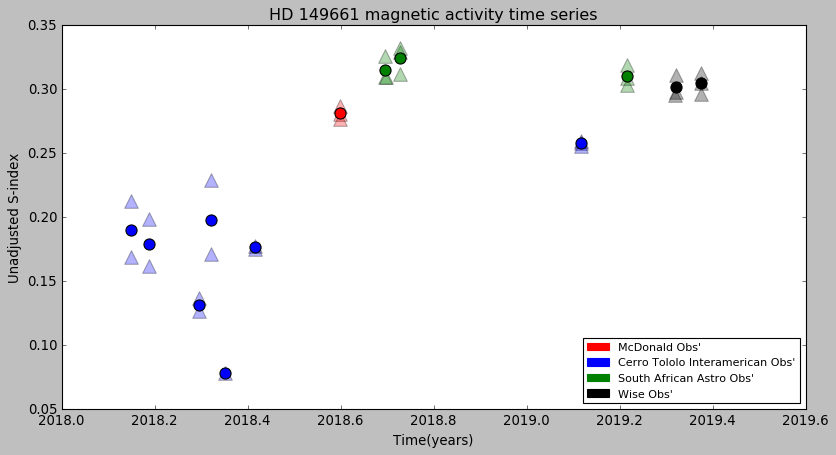

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 154417
-------------------------------------------------------------------------------
>f8
MJD: 58247.1697729 and decYr 2018.3511500627396 w/ shk: -0.3609730818672035 and offset:0.08041070420281114
bad correlation: 6.132936570959719
bad: 58247.1697729
-------------------------------------------------------------------------------
>f8
MJD: 58233.2095486 and decYr 2018.3129028728767 w/ shk: 0.12090048740539322 and offset:0.07370180249939927
bad correlation: 1.304976694414694
-------------------------------------------------------------------------------
>f8
MJD: 58209.2485161 and decYr 2018.2472562084931 w/ shk: 0.05136918035414283 and offset:0.09602321730817256
bad correlation: 1.4595021184810892
-------------------------------------------------------------------------------
MJD: 58525.3788828 and decYr 2019.1133668021919 w/ shk: 0.27671875207523927 and offset:0.08795692304320721
bad co

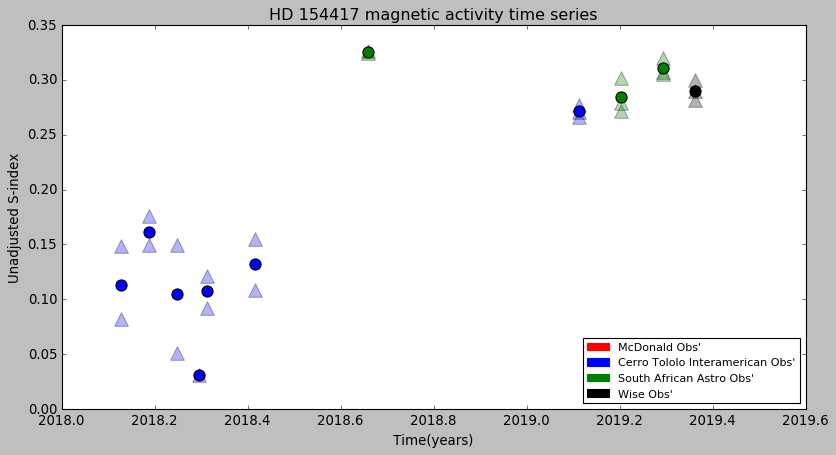

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 176051
-------------------------------------------------------------------------------
MJD: 58601.0796362 and decYr 2019.3207661265753 w/ shk: 0.20791901615806932 and offset:0.06635396761448173
bad correlation: 1.0443893150526926
-------------------------------------------------------------------------------
MJD: 58440.0877656 and decYr 2018.8796925084932 w/ shk: 0.19172473457549674 and offset:0.09104088075510566
bad correlation: 1.0518441915809322
-------------------------------------------------------------------------------
MJD: 58580.0059499 and decYr 2019.263029999726 w/ shk: 0.16885029423628692 and offset:0.06301949596458643
bad correlation: 1.0544433021639485
-------------------------------------------------------------------------------
MJD: 58601.0747102 and decYr 2019.3207526306849 w/ shk: 0.1861747790449624 and offset:0.06320830786119822
bad correlation: 1.0569913144619718
-

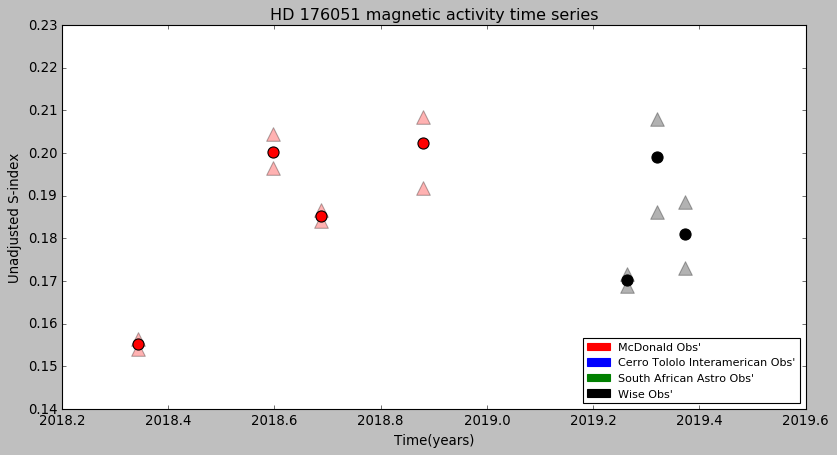

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 187691
-------------------------------------------------------------------------------
MJD: 58045.0128209 and decYr 2017.797295399726 w/ shk: 0.10563080129001227 and offset:0.008206562439164036
bad correlation: 1.3589383843575036
-------------------------------------------------------------------------------
MJD: 58271.2324698 and decYr 2018.417075259726 w/ shk: -0.0738483635033316 and offset:0.11385665895681062
bad correlation: 1.4550947875949594
bad: 58271.2324698
-------------------------------------------------------------------------------
MJD: 58297.1654942 and decYr 2018.488124641644 w/ shk: 0.07067959784989723 and offset:0.07173208972737208
bad correlation: 1.2070607940030078
-------------------------------------------------------------------------------
MJD: 58614.0264674 and decYr 2019.3562368969863 w/ shk: 0.14204300480839133 and offset:0.11394794806887089
bad correlation: 1

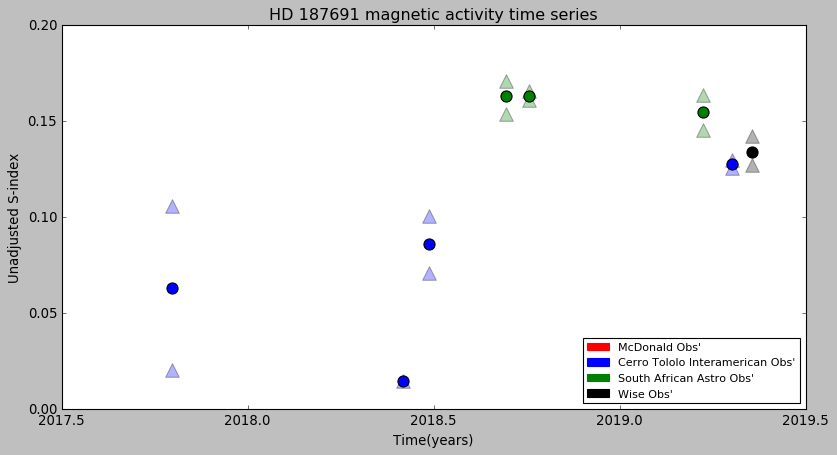

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 194012
-------------------------------------------------------------------------------
MJD: 58353.8901817 and decYr 2018.6435347443835 w/ shk: 0.24581546547958943 and offset:0.14346076569446634
bad correlation: 1.0452707783171007
-------------------------------------------------------------------------------
>f8
MJD: 58236.3499808 and decYr 2018.3215067967124 w/ shk: 2.881363496396285 and offset:-0.9263493373959235
bad correlation: 11.74213676955454
bad: 58236.3499808
-------------------------------------------------------------------------------
MJD: 58617.0672645 and decYr 2019.3645678479452 w/ shk: 0.18313946783574725 and offset:0.10716769733086552
bad correlation: 1.0704764824023647
-------------------------------------------------------------------------------
MJD: 58271.2766745 and decYr 2018.4171963684933 w/ shk: -0.06694300596240144 and offset:0.11919074211779575
bad correlatio

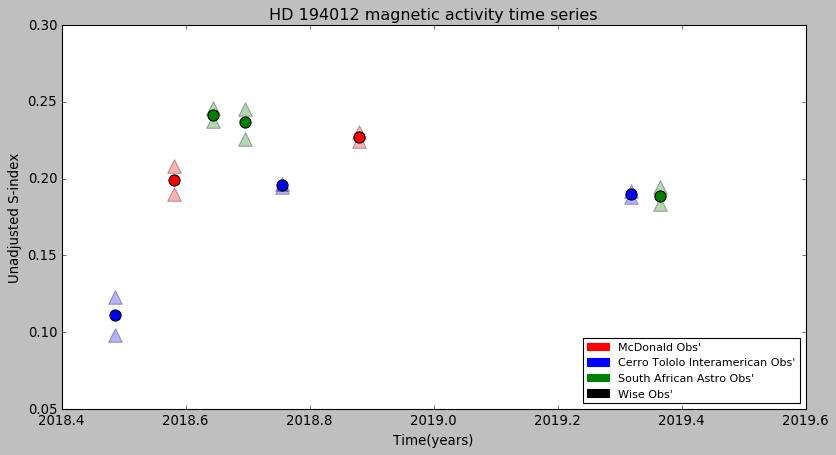

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 98230B
-------------------------------------------------------------------------------
MJD: 58600.7863952 and decYr 2019.3199627265753 w/ shk: 0.28901240321920973 and offset:0.1463815063584844
bad correlation: 1.048550827697126
-------------------------------------------------------------------------------
MJD: 58619.8486173 and decYr 2019.3721879926027 w/ shk: 0.22307045911696938 and offset:0.1535160190480752
bad correlation: 1.0600643988029235
-------------------------------------------------------------------------------
MJD: 58619.8521409 and decYr 2019.3721976463014 w/ shk: 0.19581793926326738 and offset:0.1490660784620052
bad correlation: 1.066900320068262
-------------------------------------------------------------------------------
>f8
MJD: 58244.1217852 and decYr 2018.3427994115068 w/ shk: 1.8889941363507383 and offset:-0.6893844726346342
bad correlation: 18.827053132651
bad:

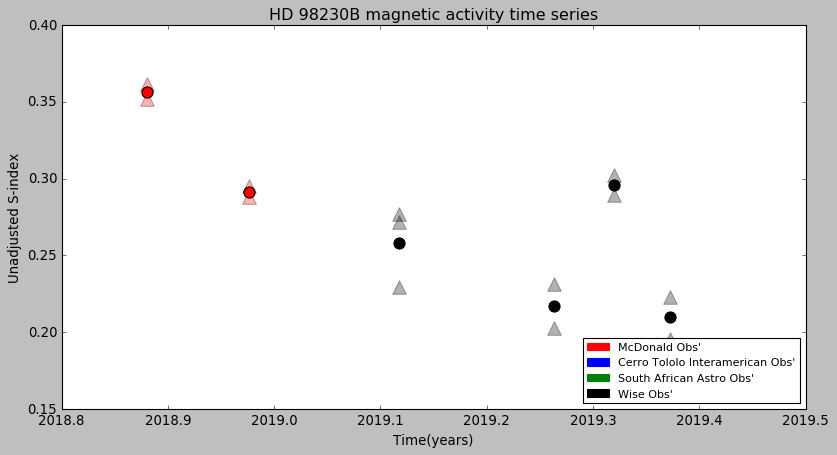

bad folder 'LabSpectra'
bad folder 'smarts'
bad folder 'oldworking'
bad folder 'flats'
bad folder 'old etc'
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 1835
-------------------------------------------------------------------------------
MJD: 58407.7766297 and decYr 2018.791168848493 w/ shk: 0.3973967846755618 and offset:0.14885579477940314
bad correlation: 1.0770496218044499
-------------------------------------------------------------------------------
MJD: 58055.0365947 and decYr 2017.8247577936986 w/ shk: -0.9875258588657837 and offset:-0.3483002483988295
bad correlation: 24.50218514364081
bad: 58055.0365947
-------------------------------------------------------------------------------
MJD: 58498.0546236 and decYr 2019.0385058180823 w/ shk: 0.2997598201825882 and offset:0.17811832442901954
bad correlation: 1.0678158422630637
-------------------------------------------------------------------------------
bad flat detected mk_

bad correlation: 1.070522900275305
-------------------------------------------------------------------------------
MJD: 58441.1600887 and decYr 2018.88263038 w/ shk: 0.39753112826618914 and offset:0.12592132859960115
bad correlation: 1.0614487590488726


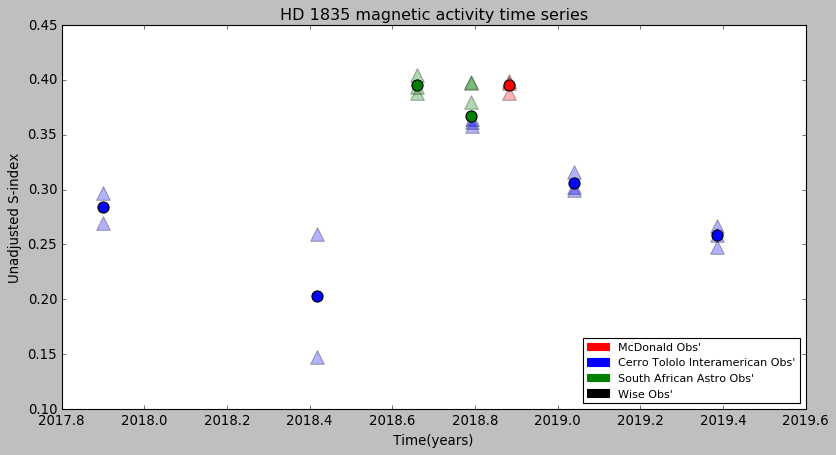

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 12235
-------------------------------------------------------------------------------
MJD: 58090.0306659 and decYr 2017.92063196137 w/ shk: 0.029348635442780626 and offset:0.1517592598534468
bad correlation: 1.7018029505209964
-------------------------------------------------------------------------------
MJD: 58511.0393952 and decYr 2019.0740805347946 w/ shk: 0.13487403330133982 and offset:0.1600089696872599
bad correlation: 1.073188632476957
-------------------------------------------------------------------------------
MJD: 58511.0442865 and decYr 2019.0740939356165 w/ shk: 0.11681269689940783 and offset:0.1543296096897424
bad correlation: 1.0817665202257534
-------------------------------------------------------------------------------
MJD: 58323.3121618 and decYr 2018.5597593473972 w/ shk: 0.09434551052520433 and offset:0.014866724225277236
bad correlation: 1.1584351802522688
----

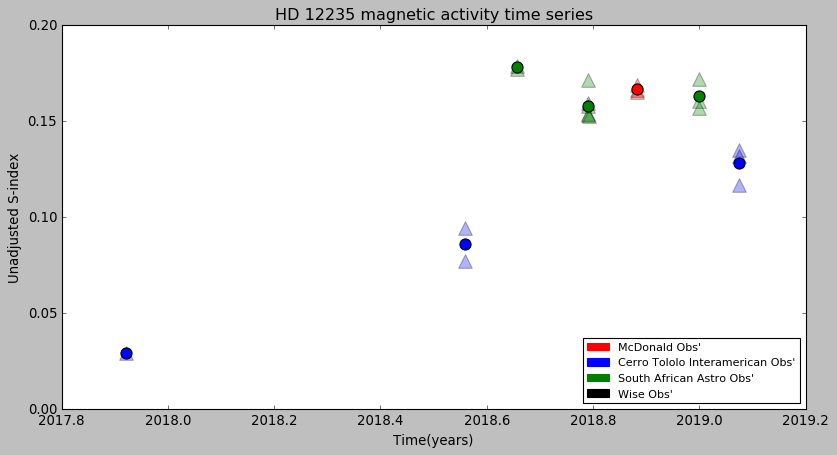

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 17051
-------------------------------------------------------------------------------
MJD: 58056.0659692 and decYr 2017.8275779978082 w/ shk: 0.11916721808536233 and offset:0.003915148185480763
bad correlation: 1.3107300484739879
-------------------------------------------------------------------------------
MJD: 58472.1244845 and decYr 2018.9674643410958 w/ shk: 0.25254689309185363 and offset:0.1878440284672543
bad correlation: 1.0458332010324014
-------------------------------------------------------------------------------
MJD: 58472.1293878 and decYr 2018.9674777747946 w/ shk: 0.2510829688624332 and offset:0.18761692762747587
bad correlation: 1.0456908676528298
-------------------------------------------------------------------------------
MJD: 58394.8368211 and decYr 2018.7557173180821 w/ shk: 0.24601155989729942 and offset:0.20462795113278814
bad correlation: 1.0479753652649055
-

bad correlation: 2.3124888289700127
bad: 58354.2323109
-------------------------------------------------------------------------------
MJD: 58394.8319412 and decYr 2018.7557039484932 w/ shk: 0.2496268083839905 and offset:0.2017873721213505
bad correlation: 1.0503738788647312
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58330.3596906 and decYr 2018.5790676454794 w/ shk: -0.34084410139393423 and offset:0.08868427899889704
bad correlation: 1.9835466492508806
bad: 58330.3596906


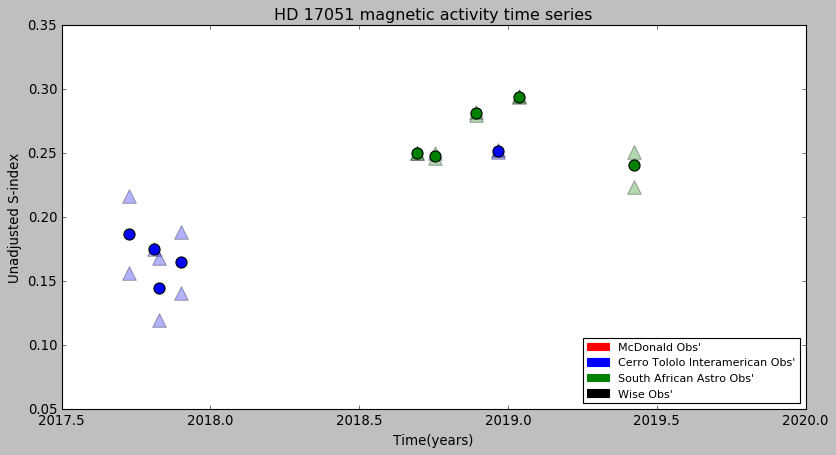

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 20630
-------------------------------------------------------------------------------
MJD: 58440.3542647 and decYr 2018.8804226430136 w/ shk: 0.41867936212649315 and offset:0.145008251447998
bad correlation: 1.0623795304340478
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58354.3155519 and decYr 2018.6447001421918 w/ shk: 0.1902005513713574 and offset:0.07310183635496229
bad correlation: 1.256765243542703
bad: 58354.3155519
-------------------------------------------------------------------------------
MJD: 58498.0854814 and decYr 2019.03859036 w/ shk: 0.342472792411326 and offset:0.2056509262845621
bad correlation: 1.0582917654476534
-------------------------------------------------------------------------------
MJD: 58498.0805898 and decYr 2019.038576958356 w/ shk: 0.3429118304382459 and offset:0.2052917813192493

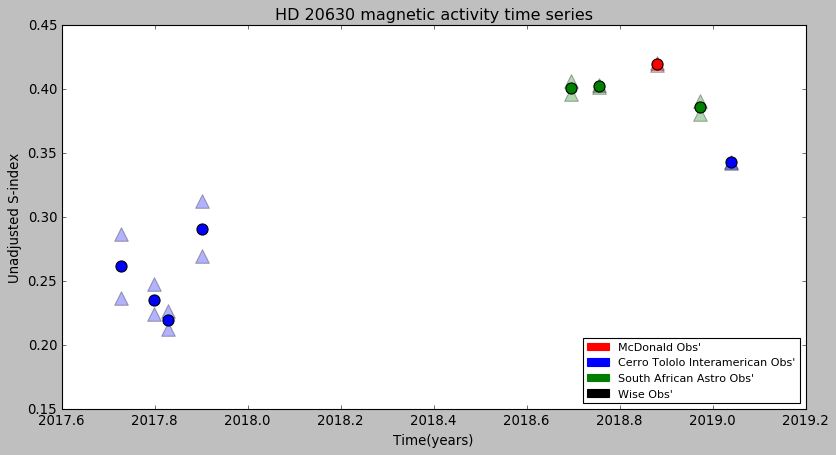

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 22049
-------------------------------------------------------------------------------
MJD: 58655.1802291 and decYr 2019.4689869290412 w/ shk: 0.42863725203935293 and offset:0.1020106988833538
bad correlation: 1.0926694941013095
-------------------------------------------------------------------------------
MJD: 58655.1851092 and decYr 2019.469000299178 w/ shk: 0.3992154453174323 and offset:0.09038755006462264
bad correlation: 1.0829971380944643
-------------------------------------------------------------------------------
MJD: 58678.3833778 and decYr 2019.532557199452 w/ shk: 0.39820867455125186 and offset:0.13236813083140297
bad correlation: 1.1119800915522808
-------------------------------------------------------------------------------
MJD: 58678.3882907 and decYr 2019.532570659452 w/ shk: 0.3986397979225222 and offset:0.1316569690086898
bad correlation: 1.1118542583144306
-------

MJD: 58394.9053518 and decYr 2018.7559050734246 w/ shk: 0.4975371187564126 and offset:0.17796721543508726
bad correlation: 1.0805480171387702
-------------------------------------------------------------------------------
MJD: 58394.9102553 and decYr 2018.7559185076711 w/ shk: 0.49959867155784016 and offset:0.1828283774763117
bad correlation: 1.0760846594439244
-------------------------------------------------------------------------------
MJD: 58434.3511998 and decYr 2018.863975889863 w/ shk: 0.3608503557539394 and offset:0.15428386291422122
bad correlation: 3.7218546444650453
bad: 58434.3511998
-------------------------------------------------------------------------------
MJD: 58019.2119561 and decYr 2017.726608098904 w/ shk: 0.3103270942527522 and offset:-0.026757315603097877
bad correlation: 1.1245659298542756


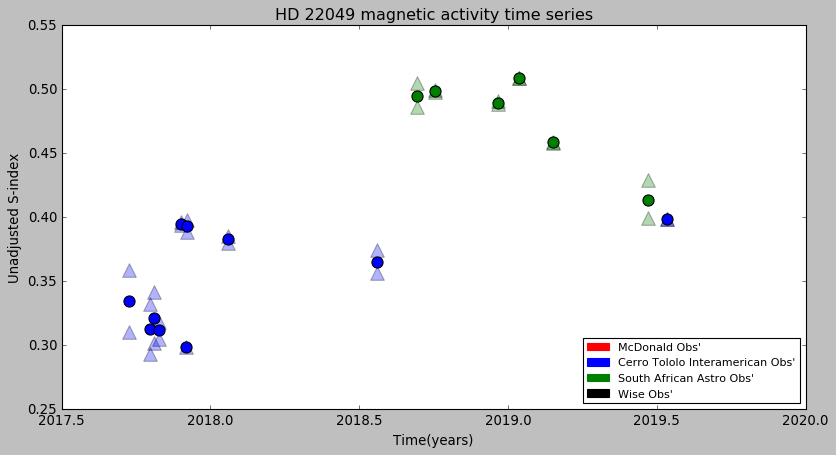

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 26913
-------------------------------------------------------------------------------
MJD: 58473.9547347 and decYr 2018.9724787252055 w/ shk: 0.3876522981887973 and offset:0.15511899743395852
bad correlation: 1.0809806273159257
-------------------------------------------------------------------------------
MJD: 58083.2333013 and decYr 2017.9020090446575 w/ shk: 0.22913846974046828 and offset:0.13954724306529875
bad correlation: 1.5237765405808128
-------------------------------------------------------------------------------
MJD: 58373.0288185 and decYr 2018.6959693657534 w/ shk: 0.40758840237293475 and offset:0.14436157316733314
bad correlation: 1.130974174969272
-------------------------------------------------------------------------------
MJD: 58394.9829239 and decYr 2018.756117599726 w/ shk: 0.40367917598737724 and offset:0.10626951945307063
bad correlation: 1.1034486482474084
---

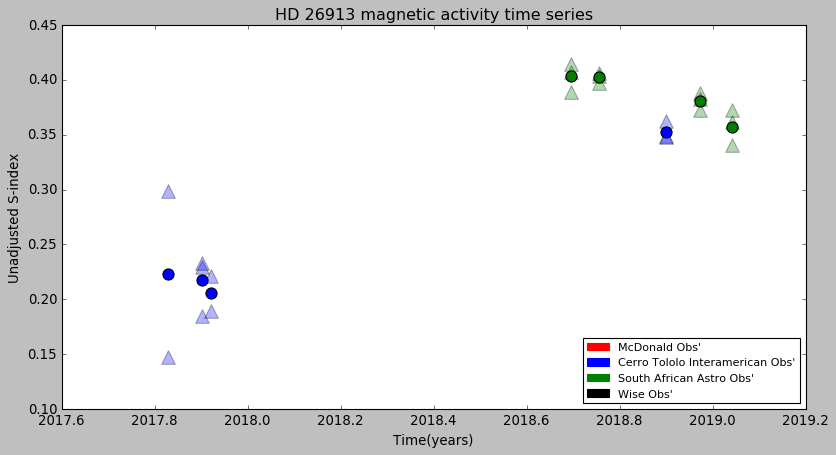

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 30495
-------------------------------------------------------------------------------
MJD: 58533.1053736 and decYr 2019.134535270137 w/ shk: 0.2669886505103061 and offset:0.20456991369013594
bad correlation: 1.0561184100041543
-------------------------------------------------------------------------------
MJD: 58360.0380357 and decYr 2018.66037818 w/ shk: 0.311799255740257 and offset:0.1658678587417666
bad correlation: 1.0645752358131508
-------------------------------------------------------------------------------
MJD: 58441.2432929 and decYr 2018.8828583367124 w/ shk: 0.28107402960907213 and offset:0.1529667927117979
bad correlation: 1.0907050285393611
-------------------------------------------------------------------------------
>f8
MJD: 58173.082051 and decYr 2018.1481700027398 w/ shk: 0.06208674041512375 and offset:0.17931514915676763
bad correlation: 2.0315044426784543
bad: 581

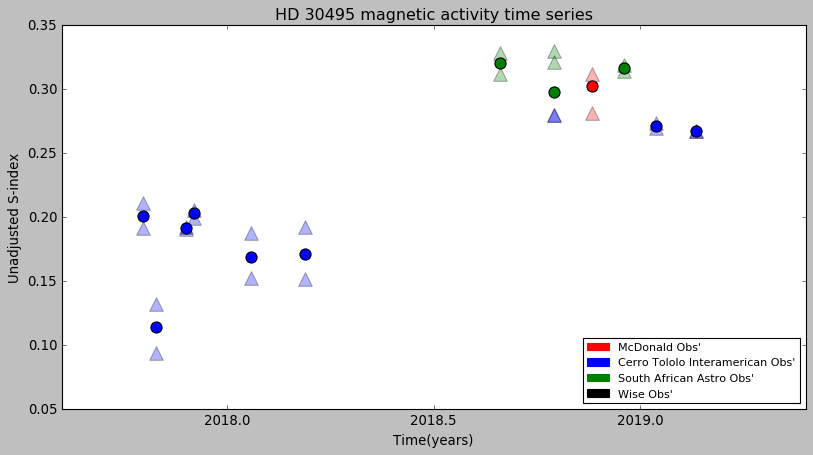

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 37394
-------------------------------------------------------------------------------
MJD: 58440.1805566 and decYr 2018.879946730411 w/ shk: 0.4056318999777287 and offset:0.11493562539552447
bad correlation: 1.1150720881249598
-------------------------------------------------------------------------------
MJD: 58440.1882182 and decYr 2018.879967721096 w/ shk: 0.41307105055138327 and offset:0.10659452365976771
bad correlation: 1.1020882968482684
-------------------------------------------------------------------------------
MJD: 58091.135924 and decYr 2017.9236600657534 w/ shk: 0.39986542182925944 and offset:0.11435616462988286
bad correlation: 1.1028911809500472
-------------------------------------------------------------------------------
MJD: 58440.1958919 and decYr 2018.8799887449316 w/ shk: 0.40849811423850424 and offset:0.1067064939646349
bad correlation: 1.1012264561953822
-----

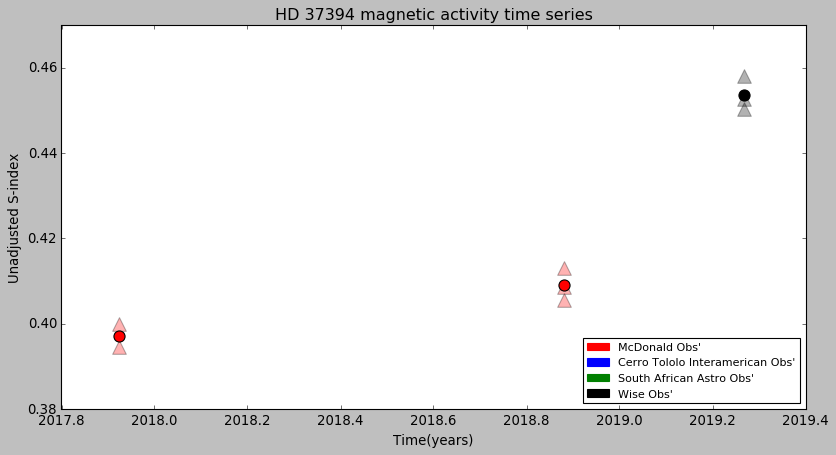

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 43587
-------------------------------------------------------------------------------
MJD: 58362.1473409 and decYr 2018.6661570983563 w/ shk: 0.17391989313447617 and offset:0.12102496544221626
bad correlation: 1.0569566384920484
-------------------------------------------------------------------------------
MJD: 58373.1100649 and decYr 2018.6961919586302 w/ shk: 0.17178358995806756 and offset:0.1299657915218221
bad correlation: 1.0522312902949613
-------------------------------------------------------------------------------
MJD: 58601.7154846 and decYr 2019.3225081769863 w/ shk: 0.16563926399813442 and offset:0.1530121098667566
bad correlation: 1.067069420589028
-------------------------------------------------------------------------------
MJD: 58395.0605136 and decYr 2018.7563301742466 w/ shk: 0.17233375485201644 and offset:0.1500442360836158
bad correlation: 1.0594249732383763
----

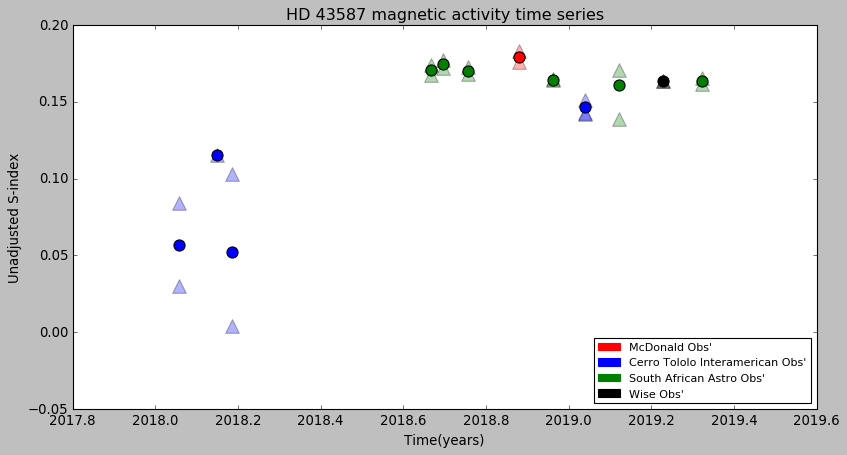

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 49933
-------------------------------------------------------------------------------
>f8
MJD: 58187.046957 and decYr 2018.186430019178 w/ shk: 0.07427970670068142 and offset:0.14259205914025788
bad correlation: 2.0166316249406613
bad: 58187.046957
-------------------------------------------------------------------------------
MJD: 58140.0914874 and decYr 2018.0577848969863 w/ shk: -0.052227818449466695 and offset:0.12058065845286083
bad correlation: 4.237160211341889
bad: 58140.0914874
-------------------------------------------------------------------------------
MJD: 58083.2130055 and decYr 2017.901953439726 w/ shk: -0.002197817466855023 and offset:0.08315201385761434
bad correlation: 2.549812480730371
bad: 58083.2130055
-------------------------------------------------------------------------------
MJD: 58440.3088395 and decYr 2018.880298190411 w/ shk: 0.27169305581723013 and offse

bad correlation: 5.062890401623612
bad: 58089.1604033
-------------------------------------------------------------------------------
MJD: 58497.8361431 and decYr 2019.0379072413698 w/ shk: 0.2572709608974576 and offset:0.08708135395832677
bad correlation: 1.043725000991771
-------------------------------------------------------------------------------
MJD: 58528.8615454 and decYr 2019.1229083435617 w/ shk: 0.2586105352225693 and offset:0.13379597440259142
bad correlation: 1.0311742535457313
-------------------------------------------------------------------------------
MJD: 58067.2401436 and decYr 2017.8581921742466 w/ shk: -0.03104272329616292 and offset:-0.38089234095763896
bad correlation: 2.7295047899815272
bad: 58067.2401436
-------------------------------------------------------------------------------
MJD: 58566.7500085 and decYr 2019.2267123520548 w/ shk: 0.2208028723130574 and offset:0.1628104878532567
bad correlation: 1.077113427093257
---------------------------------------

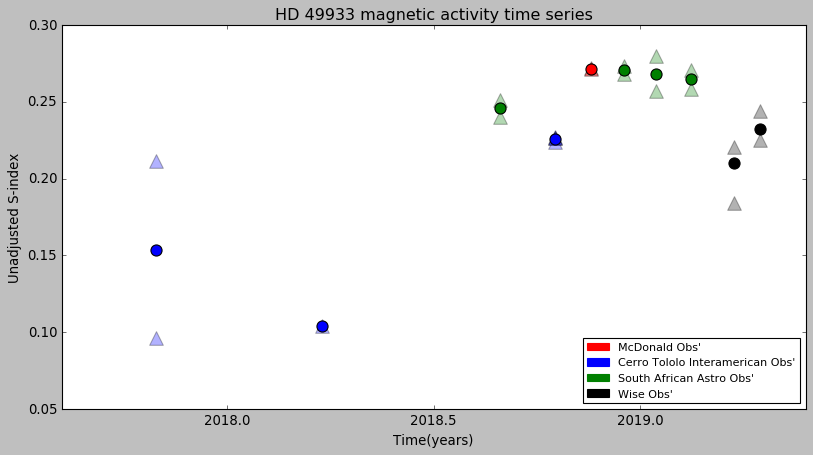

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 75332
-------------------------------------------------------------------------------
MJD: 58441.3487862 and decYr 2018.883147359452 w/ shk: 0.3259364372702028 and offset:0.12455316549957171
bad correlation: 1.0548197807989186
-------------------------------------------------------------------------------
MJD: 58091.2748 and decYr 2017.9240405479452 w/ shk: 0.16294035008279054 and offset:0.10018760138321078
bad correlation: 1.433871082653443
-------------------------------------------------------------------------------
MJD: 58091.2696238 and decYr 2017.9240263665754 w/ shk: 0.13740843265481387 and offset:0.08706562063340997
bad correlation: 1.4246530261195591
-------------------------------------------------------------------------------
MJD: 58441.3411239 and decYr 2018.8831263668494 w/ shk: 0.31972188140886626 and offset:0.10881391044854975
bad correlation: 1.0420553245986637
------

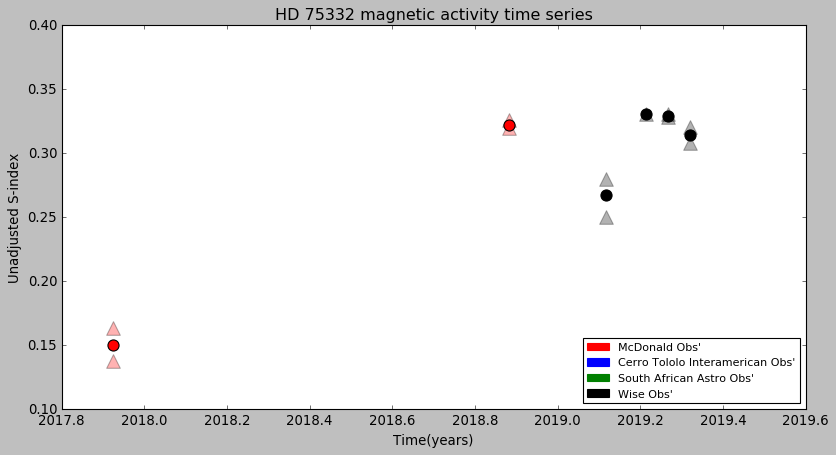

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 76151
-------------------------------------------------------------------------------
MJD: 58271.9762173 and decYr 2018.4191129241096 w/ shk: 0.18073163096325653 and offset:0.22221946762718497
bad correlation: 1.237633728399961
-------------------------------------------------------------------------------
MJD: 58528.2832817 and decYr 2019.121324059452 w/ shk: 0.20683479126872253 and offset:0.1920994641449046
bad correlation: 1.0718819953952685
-------------------------------------------------------------------------------
>f8
MJD: 58173.1102551 and decYr 2018.1482472742466 w/ shk: 0.14180118856714305 and offset:0.1706372815501158
bad correlation: 1.1649653953349426
-------------------------------------------------------------------------------
MJD: 58083.2690157 and decYr 2017.9021068923287 w/ shk: 0.14192288283310564 and offset:0.15400758870516784
bad correlation: 1.2914022712364153


MJD: 58140.1655615 and decYr 2018.057987839726 w/ shk: 0.16803417169226723 and offset:0.07072062925127034
bad correlation: 1.2769938423835747
-------------------------------------------------------------------------------
MJD: 58140.1728068 and decYr 2018.058007689863 w/ shk: 0.13595013551572718 and offset:0.0710624832434445
bad correlation: 1.211531857278427
-------------------------------------------------------------------------------
>f8
MJD: 58231.04338 and decYr 2018.3069681643835 w/ shk: 0.17737236652152716 and offset:0.1976682096250412
bad correlation: 1.2283170287363723
-------------------------------------------------------------------------------
>f8
MJD: 58232.9950646 and decYr 2018.3123152454793 w/ shk: 0.14616309073870395 and offset:0.1965444622161102
bad correlation: 1.2252469028257853
-------------------------------------------------------------------------------
MJD: 58271.9834734 and decYr 2018.4191328038357 w/ shk: 0.17425911433696212 and offset:0.21892978086822024
b

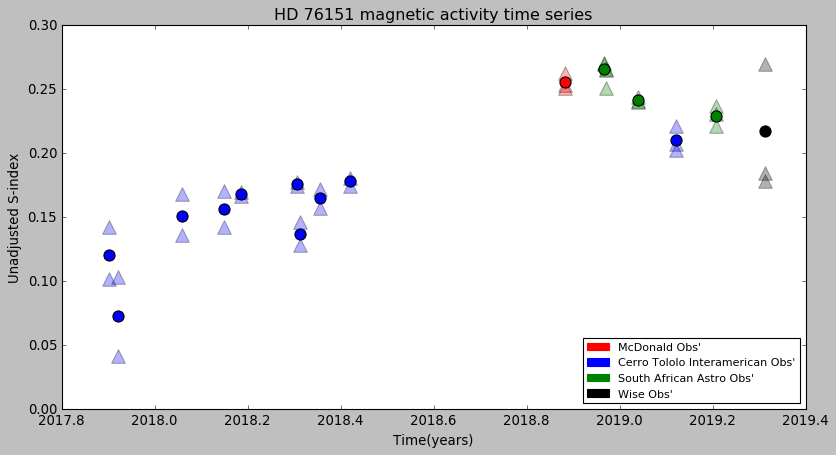

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 78366
-------------------------------------------------------------------------------
MJD: 58598.7673169 and decYr 2019.3144310052055 w/ shk: 0.2855458323126831 and offset:0.21774821283878787
bad correlation: 1.0705515149084661
-------------------------------------------------------------------------------
MJD: 58633.7775309 and decYr 2019.410349399726 w/ shk: 0.32342440664355265 and offset:0.20922353224563647
bad correlation: 1.621261735402532
-------------------------------------------------------------------------------
MJD: 58555.964967 and decYr 2019.1971642931508 w/ shk: 0.26357513601758165 and offset:0.09161506726919288
bad correlation: 1.3120892731259852
-------------------------------------------------------------------------------
MJD: 58555.9551377 and decYr 2019.1971373635618 w/ shk: 0.3077438247037742 and offset:0.2324945838554114
bad correlation: 1.2420766034495199
------

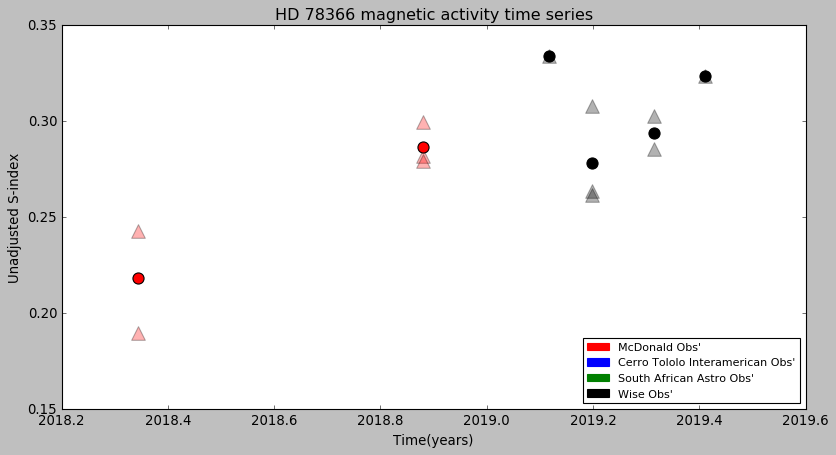

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 82443
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58580.0786288 and decYr 2019.26322912 w/ shk: 0.768137311935717 and offset:0.18972625675503432
bad correlation: 1.096002016280215
bad: 58580.0786288
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58580.0674917 and decYr 2019.2631986073973 w/ shk: 0.7693144939048511 and offset:0.18967131664657477
bad correlation: 1.090463828549058
bad: 58580.0674917
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58580.0563406 and decYr 2019.2631680564384 w/ shk: 0.7828393482477932 and offset:0.188191101274103
bad correlation: 1.0988890437946182
bad: 58580.0563406


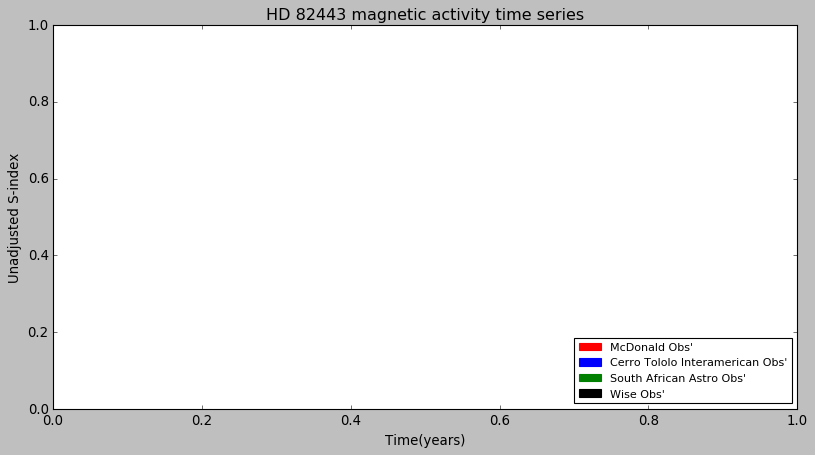

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 82885
-------------------------------------------------------------------------------
MJD: 58526.7242673 and decYr 2019.1170527871234 w/ shk: 0.27484473265897097 and offset:0.22614790255114728
bad correlation: 1.0891584696174308
-------------------------------------------------------------------------------
MJD: 58597.8513447 and decYr 2019.3119214923288 w/ shk: 0.28519028574562993 and offset:0.20212877753560557
bad correlation: 1.0953141468897412
-------------------------------------------------------------------------------
MJD: 58526.730561 and decYr 2019.117070030137 w/ shk: 0.2883194034261713 and offset:0.1724719607873246
bad correlation: 1.090875202368833
-------------------------------------------------------------------------------
MJD: 58555.9896441 and decYr 2019.1972319016438 w/ shk: 0.2977256872806714 and offset:0.16699051465908837
bad correlation: 1.1853856685277753
------

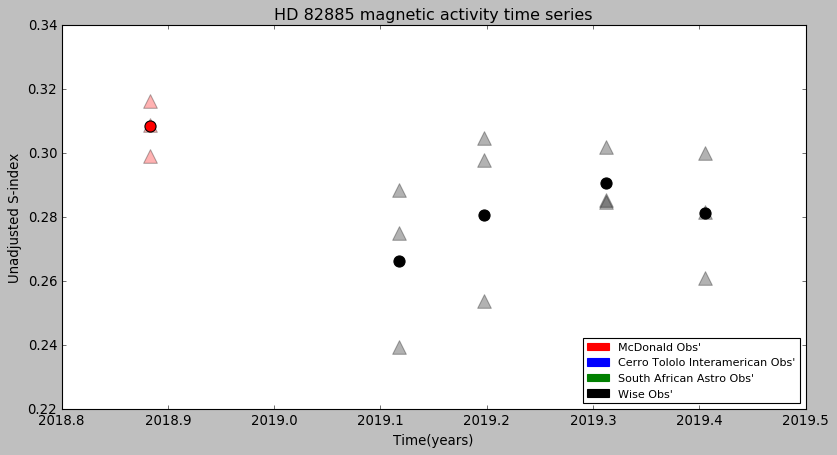

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 88737
-------------------------------------------------------------------------------
MJD: 58621.8300506 and decYr 2019.3776165769864 w/ shk: 0.21695932163779624 and offset:0.2081332033708973
bad correlation: 1.1186425407010931
-------------------------------------------------------------------------------
MJD: 58498.028115 and decYr 2019.0384331917808 w/ shk: 0.2558723146847894 and offset:0.10045929692857868
bad correlation: 1.0543566827080275
-------------------------------------------------------------------------------
MJD: 58498.035789 and decYr 2019.0384542164384 w/ shk: 0.26723609808891113 and offset:0.0827230661340629
bad correlation: 1.0474452683330109
-------------------------------------------------------------------------------
MJD: 58140.2213334 and decYr 2018.058140639452 w/ shk: 0.07879182230397182 and offset:0.043246209942360656
bad correlation: 2.887870630896719
bad: 5

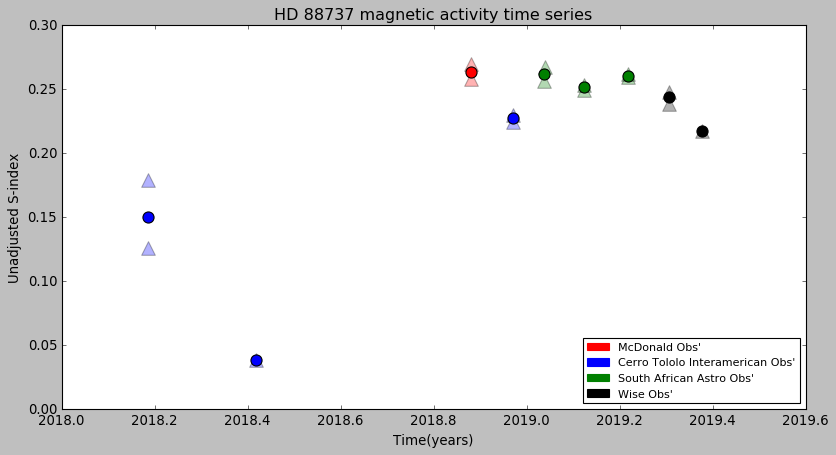

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 100180
-------------------------------------------------------------------------------
MJD: 58441.4728857 and decYr 2018.8834873580822 w/ shk: 0.20211091259776842 and offset:0.058470421889376456
bad correlation: 1.079830412159559
-------------------------------------------------------------------------------
MJD: 58595.8331048 and decYr 2019.3063920679451 w/ shk: 0.18125660817389633 and offset:0.16546449550924802
bad correlation: 1.0713632240127031
-------------------------------------------------------------------------------
MJD: 58621.8510189 and decYr 2019.3776740243836 w/ shk: 0.17648172312698648 and offset:0.1739890847246882
bad correlation: 1.1546301157465253
-------------------------------------------------------------------------------
MJD: 58140.2492359 and decYr 2018.0582170846576 w/ shk: 2.186642618869979 and offset:-0.9033304266882546
bad correlation: 12.798025687287407
ba

MJD: 58534.3477631 and decYr 2019.1379390769862 w/ shk: 0.1356881466969841 and offset:0.11762797951210784
bad correlation: 1.0641567429780865
-------------------------------------------------------------------------------
MJD: 58140.2433819 and decYr 2018.0582010463013 w/ shk: -4.088907469457183 and offset:-0.013480327200129533
bad correlation: 15.377355596605021
bad: 58140.2433819
-------------------------------------------------------------------------------
>f8
MJD: 58173.1543568 and decYr 2018.148368100822 w/ shk: 1.7253868691198768 and offset:-0.9714747714203655
bad correlation: 7.891307877857403
bad: 58173.1543568


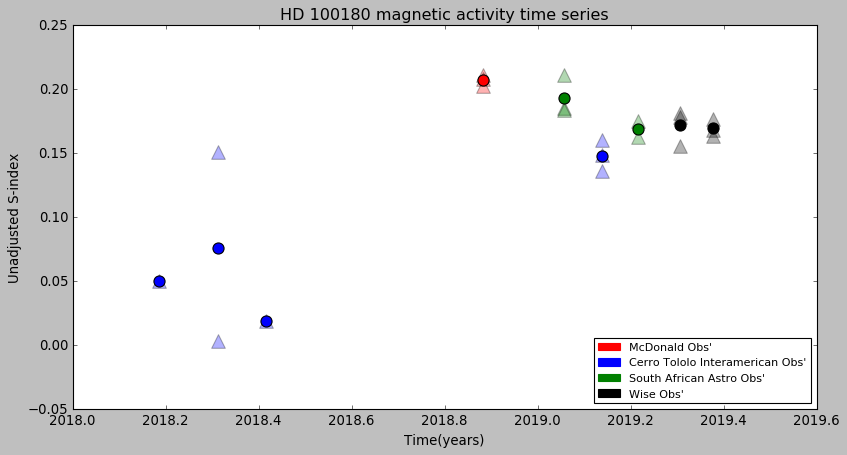

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 115383
-------------------------------------------------------------------------------
MJD: 58269.9887802 and decYr 2018.413667890959 w/ shk: 0.04495862731573076 and offset:0.1335265209773227
bad correlation: 1.6190265485398705
-------------------------------------------------------------------------------
>f8
MJD: 58227.0653817 and decYr 2018.296069538904 w/ shk: 0.09399428298214442 and offset:0.09066935036465892
bad correlation: 1.8017583242532351
-------------------------------------------------------------------------------
MJD: 58558.0769376 and decYr 2019.2029505139726 w/ shk: 0.3655761746005856 and offset:0.0807466366720624
bad correlation: 1.0528623922712455
-------------------------------------------------------------------------------
MJD: 58480.4264942 and decYr 2018.9902095731507 w/ shk: 0.3700611374752836 and offset:0.03326028105704903
bad correlation: 1.0494426543650932
-

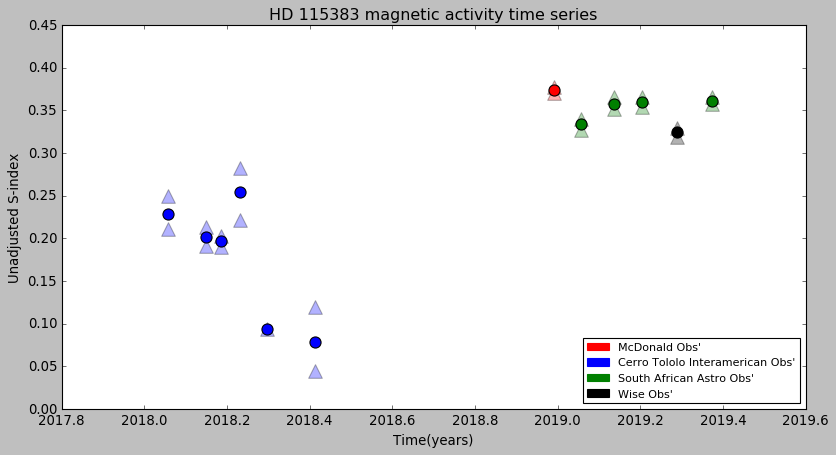

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 120136
-------------------------------------------------------------------------------
>f8
MJD: 58228.108911 and decYr 2018.2989285232877 w/ shk: -0.04386845327411009 and offset:0.09558144499216076
bad correlation: 3.071230644730734
bad: 58228.108911
-------------------------------------------------------------------------------
>f8
MJD: 58232.1001524 and decYr 2018.3098634312328 w/ shk: -0.038931391048939945 and offset:0.10194720810158231
bad correlation: 3.3468092528334554
bad: 58232.1001524
-------------------------------------------------------------------------------
MJD: 58270.9921401 and decYr 2018.4164168221919 w/ shk: 0.03999039971628261 and offset:0.1535884697809949
bad correlation: 1.8385123027689643
-------------------------------------------------------------------------------
>f8
MJD: 58232.1025387 and decYr 2018.309869969041 w/ shk: -0.023361991204107757 and offset:0.100

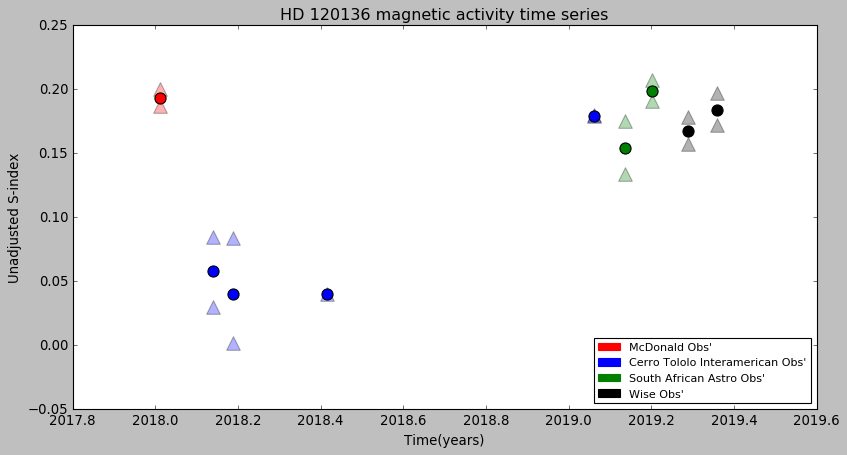

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 136202
-------------------------------------------------------------------------------
>f8
MJD: 58246.0754781 and decYr 2018.3481519947945 w/ shk: -0.49967296432381486 and offset:0.18467196237787223
bad correlation: 9.561242297824046
bad: 58246.0754781
-------------------------------------------------------------------------------
>f8
MJD: 58246.0782072 and decYr 2018.3481594717807 w/ shk: -0.4013756787966447 and offset:0.1877956473034913
bad correlation: 10.750928118219386
bad: 58246.0782072
-------------------------------------------------------------------------------
MJD: 58534.0510838 and decYr 2019.1371262569862 w/ shk: 0.1762676482064393 and offset:0.1695030215961023
bad correlation: 1.1144802986453524
-------------------------------------------------------------------------------
>f8
MJD: 58166.3875519 and decYr 2018.1298289093152 w/ shk: 0.036395917852062684 and offset:0.15157

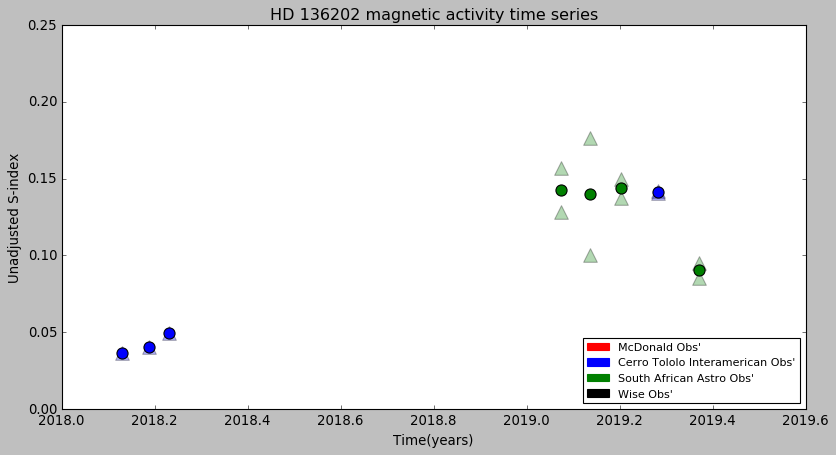

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 152391
-------------------------------------------------------------------------------
MJD: 58383.7390861 and decYr 2018.7253125646575 w/ shk: 0.4091088758166144 and offset:0.26325100405263174
bad correlation: 1.0948752445504517
-------------------------------------------------------------------------------
MJD: 58558.1241827 and decYr 2019.2030799526028 w/ shk: 0.397902558507582 and offset:0.13154824603013343
bad correlation: 1.1044033374771394
-------------------------------------------------------------------------------
MJD: 58558.1318558 and decYr 2019.2031009747946 w/ shk: 0.38225552801254137 and offset:0.18495677214011913
bad correlation: 1.0980972696538598
-------------------------------------------------------------------------------
MJD: 58599.1448531 and decYr 2019.315465350959 w/ shk: 0.33905977637155355 and offset:0.1435188384098642
bad correlation: 1.0916975331396714
----

bad correlation: 3.3463437547633124
bad: 58619.8185974


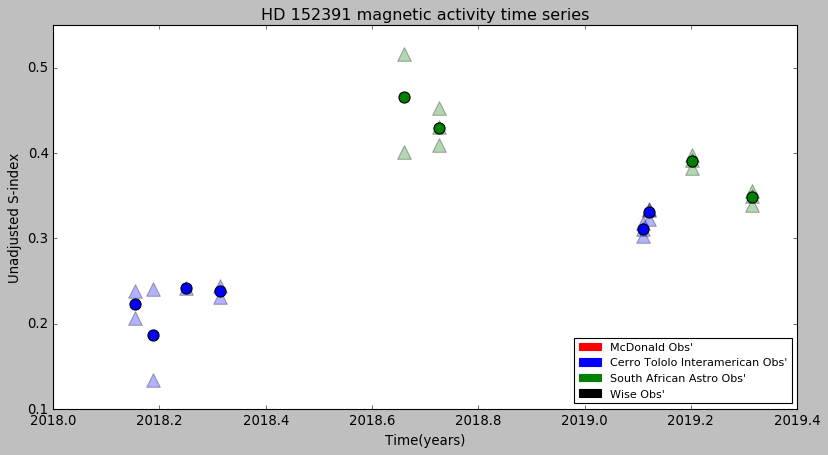

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 182101
-------------------------------------------------------------------------------
MJD: 58271.2079556 and decYr 2018.4170080975343 w/ shk: -0.4163667039526325 and offset:0.09984708488747308
bad correlation: 3.46108185706481
bad: 58271.2079556
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58305.1097391 and decYr 2018.5098896961645 w/ shk: 0.04614283897107064 and offset:0.1221352407551717
bad correlation: 3.87938698008363
bad: 58305.1097391
-------------------------------------------------------------------------------
MJD: 58592.0311871 and decYr 2019.2959758550685 w/ shk: 0.22946179443461104 and offset:0.09542657563120238
bad correlation: 1.3906813854937985
-------------------------------------------------------------------------------
bad flat detected mk_flatolap.py
MJD: 58305.10528 and decYr 2018.50987747945

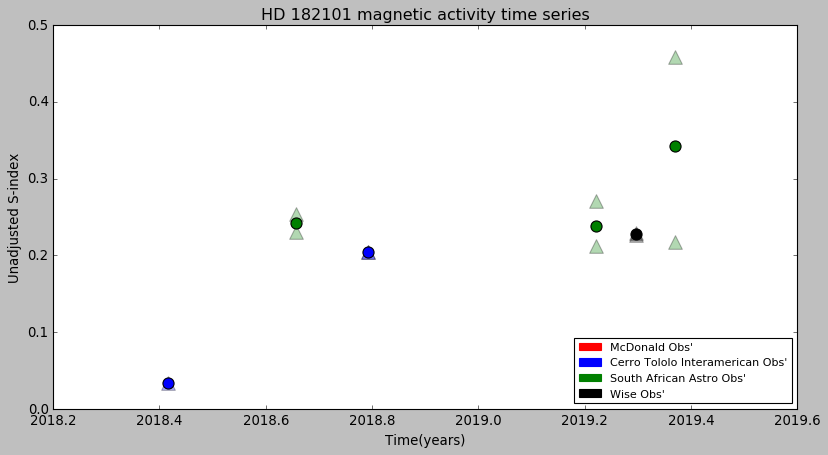

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 190406
-------------------------------------------------------------------------------
MJD: 58620.0038947 and decYr 2019.372613410137 w/ shk: 0.18351884089950682 and offset:0.12263356246084871
bad correlation: 1.061990424888422
-------------------------------------------------------------------------------
MJD: 58297.1813422 and decYr 2018.4881680608219 w/ shk: 0.12033989085458908 and offset:0.07891142258908466
bad correlation: 1.165072608773331
-------------------------------------------------------------------------------
MJD: 58589.9949145 and decYr 2019.2903970260274 w/ shk: 0.1445405932926692 and offset:0.11701744307223594
bad correlation: 1.1154939692187877
-------------------------------------------------------------------------------
>f8
MJD: 58230.370616 and decYr 2018.3051249753426 w/ shk: 0.148434368187166 and offset:0.09063461576794316
bad correlation: 1.975116802683393
---

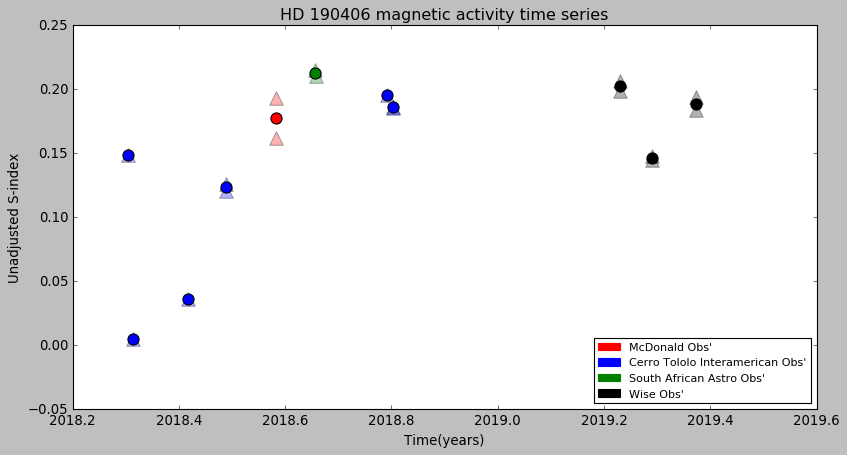

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 206860
-------------------------------------------------------------------------------
MJD: 58271.3181809 and decYr 2018.4173100846576 w/ shk: 0.1353538482584744 and offset:0.08882769681844956
bad correlation: 2.0527996468638445
bad: 58271.3181809
-------------------------------------------------------------------------------
MJD: 58337.2386299 and decYr 2018.5979140545205 w/ shk: 0.3751902909227862 and offset:0.11539351205365325
bad correlation: 1.058380324567542
-------------------------------------------------------------------------------
MJD: 58045.0252605 and decYr 2017.7973294808219 w/ shk: -0.008407931165815131 and offset:-0.03477209471297458
bad correlation: 4.855584562822753
bad: 58045.0252605
-------------------------------------------------------------------------------
MJD: 58092.1068383 and decYr 2017.9263201049316 w/ shk: 2.271979264210057 and offset:-0.9629244484470746


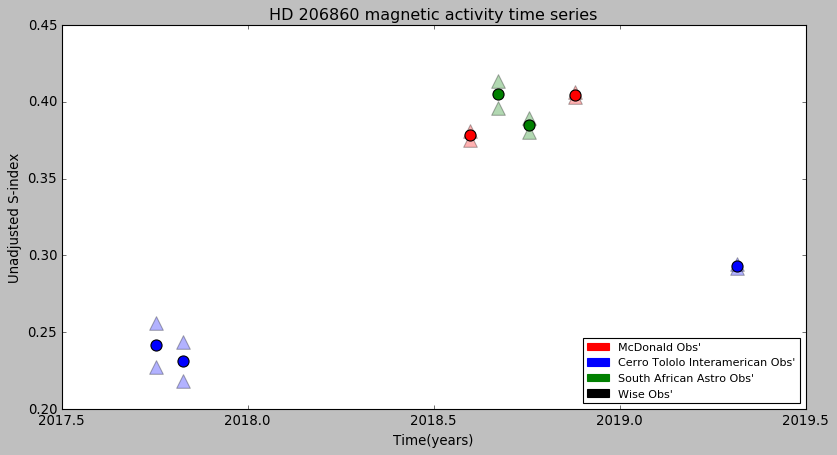

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 165341A
-------------------------------------------------------------------------------
>f8
MJD: 58188.3521068 and decYr 2018.1900057720547 w/ shk: 5.553202605597292 and offset:-1.000934710624209
bad correlation: 14.638400518516043
bad: 58188.3521068
-------------------------------------------------------------------------------
>f8
MJD: 58209.2939388 and decYr 2018.2473806542466 w/ shk: 1.450734911481084 and offset:-0.8746747860349755
bad correlation: 9.621088855579059
bad: 58209.2939388
-------------------------------------------------------------------------------
>f8
MJD: 58232.250026 and decYr 2018.3102740438355 w/ shk: 0.8416096534089633 and offset:-0.7905632878321516
bad correlation: 10.136307764203014
bad: 58232.250026
-------------------------------------------------------------------------------
MJD: 58271.1519241 and decYr 2018.4168545865753 w/ shk: 3.7108939203620426 and of

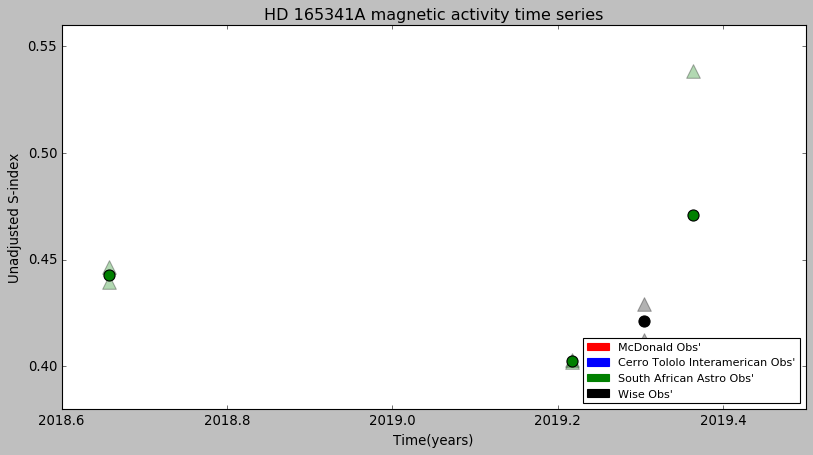

In [3]:
#this is the BIG wrapper. This handles all the folder structure stuff and manages the
#pipeline. The general outline of pipeline is;
#import data to arrays
#create flat field
#remove instrumental error by dividing out flat field
#align stellar spectrum to reference by cross correlation
#find ca HK emission reversal and calculate s-index(shk)
#detect bad spectra and erronous data and remove from final product
#Sum spectra from each night(2-3 obs per night) to increase signal/noise
#Calculate S-index for each nights combined data
#print intermediate pdfs(for single and combined obs) for debugging into output folder
#plot final time series of star with all good data included
#loop through each star as desired
import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os
import helpers as h

from calc_shk import calc_targOlapf
from calc_shk import calc_shk


from pipeline import load_folder_for_pipeline
from pipeline import sum_daily_data
from pipeline import plot_daily_data_timeseries

from calc_del_lambda import calc_del_lam
from helpers import pdf_from_data
from helpers import mkdir_p
from helpers import bad_spec_detection
from helpers import bad_spec_detection_v2

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
#from matplotlib.backends.backend_pdf import PdfPages

#todo clean and place into healpers file
def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey

def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)

def is_folder_star(folder):
    try:
        #if first letter is number we can run pipeline on it
        int(folder[0])
        return True
    except ValueError:
        return False
    
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

setName = ''

#resolution for printing
res = .01
label =''



#todo fill this to print out in 
bad = []#[58330.3596906,58330.3634695,
      # 58553.7527935,58553.7479017,
      # 58272.4211262,58272.4248934,
      # 58354.2323109,58354.2381758]

#a list of stars we MUST run, regardless of if there is already output
forceRun = ["22049"]#["76151","22049"]
    
    
    
stars = get_immediate_subdirectories(dataPath)
    
#loop through every folder in the data files path. 
#these folders hold all the data for each star
for s in stars:
    if not is_folder_star(s):
        print('bad folder \'' + s + '\'')
        continue
    #if the star has an output folder and isnt forced to run we won't run again
    if os.path.exists(outputPath+s+'/') and s not in forceRun:
        print("HD " + s + " already has output")
        continue
    
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Running pipeline on HD " + s)
    setName = s
    #need blank arrays to append to since we don't know length due to bad spectra
    data = [[],[],[],[]]
    dailyData = dict()

    #we're going to loop through all folders in a stars data and determine if each is 
    #old or new format once thats determined we get the wave/flat/spec data differently
    #then we should not care about the format anymore and will do the pipeline as normal
    for path, subdirs, files in os.walk(dataPath + setName):
        #walk through each folder this is the main loop over all observations
        #each dir here should only contain one observation
        for dirs in subdirs:
            if dirs == 'flats':
                continue

            print('-------------------------------------------------------------------------------')
            curFiles = os.listdir(os.path.join(path,dirs))
            #print('loading ' + dirs)


            #TODO CLOSE FITS FILES (&*$)@&*$)@&*#$)@#$
            folderRet = load_folder_for_pipeline(path, dirs, curFiles)

            waveGrid = folderRet[0]#key for pipeline
            spec = folderRet[1]#key for pipeline
            header = folderRet[2]
            obsFileName = folderRet[3]
            old = folderRet[4]#is old format or not, for debugging
            
            #if you have data from a different system you may just want to simulate the header
            #dictionary.
            mjd = header['MJD-OBS']
            site = header['SITEID']


            decimalYr = Time(mjd,format='mjd')
            decimalYr.format = 'decimalyear'
            label=str(mjd).replace('.','/') 

            tempEff = h.tEffLookup[setName.strip('/')]

            #title for pdfs
            title = ''
            #BEGIN FORMAT INDEPENDANT CODE(HOPEFULLY)



            #try to find a flat otherwise fail
            #try:
            fD = flatDict[site]
            #flatDates = list(flatDict.keys())
            #flatDates.sort(key=lambda x: abs(x - mjd))
            fK = closestKey(fD,float(mjd))

            flatFilePath = fD[fK]

            fHDu = astropy.io.fits.open(os.path.join(path,flatFilePath))

            flat = fHDu[0].data#key for pipeline


            #if abs(mjd-fK) > 25:
            #    print('BAD BAD closest for: '+str(mjd) +' is '+ str(abs(mjd-fK)))
            #elif abs(mjd-fK) > 2:
            #    print('closest for: '+str(mjd) +' is '+ str(abs(mjd-fK)))


            #give multiple arrays of flats whose lam values are stored in multiple wave grid arrays
            flatRet = mk_flatolap(waveGrid, flat)

            #except:
               # print('bad flat find with site: ' + site + ' and date ' + str(obsDate))
                #continue


            #return one flat array with lambda grid
            flatOlap = flatRet[1]
            lamGrid = flatRet[0]


            #get the target data minus the flat
            targOlapf = calc_targOlapf(lamGrid, waveGrid, spec, flatOlap, label)


            #cross correlation returns a lambda offset(dlam) and save the lab spectra
            correlation = calc_del_lam(lab[0]/10,lab[1], lamGrid, targOlapf,res)
            dLam = correlation[0]
            labSpec = correlation[2]


            #radial velocity calculation
            #lamRef = 396.85
            #delta lamda / ref lamda * speed of light
           # rv = dLam/ lamRef * sc.c 
            #rv from meters to km/s as desired by hk_windows
            #atm we're not going to apply the radial velocity and just use the adjusted spectra
            rv = 0#rv/10000 




            #find SHK with new offset to lamda grid
            shkRet = calc_shk(lamGrid-dLam, targOlapf, rv, teff=tempEff)
            shk = shkRet[0]
            windows = shkRet[1]
            
            #if old:
             #   shk=shk*2
            print('MJD: ' + str(mjd) + ' and decYr ' + str(decimalYr) + ' w/ shk: ' + str(shk) + ' and offset:' + str(dLam))

            
            #time to toss bad spec so they won't be summed
            badSpec = False
            #not included but may need to be, check if any values of targolapf
            #are negative. Makes sense to me that those spectra should be tossed
            badSpec = bad_spec_detection_v2(lamGrid-dLam,targOlapf)          
            
            #among other things?!
            if shk < 0 or shk > 1 or flatRet[2] == True:
                badSpec = True          

            if badSpec:
                bad.append(mjd)
                title +='BAD '

            #create the directories for pdf plotting and save every intermediate data array
            first = label.split("/")[0]
            second = label.split("/")[1]
            mkdir_p("output/"+setName+"/"+first+'/')

            np.savez("output/"+setName+"/"+first+"/"+ second+"_data", targOlapf=targOlapf,flatOlap=flatOlap, lamGrid=lamGrid, adjLamGrid=lamGrid-dLam,windows=windows)




            title += 'NRES spectra, ' + site +', '+header['DATE-OBS']+' ('+ '{:.6}'.format(decimalYr.value) +'), S='+'{:.4}'.format(shk)
            pdf_from_data(lamGrid, labSpec,lamGrid-dLam, targOlapf, windows,title, "output/"+setName+"/"+first+"/",second,flatOlap,.3)



            if(badSpec):
                print('bad: ' + str(mjd))
                continue

            #OUTPUT FOR FURTHER PRINTING
            data[0].append(mjd)
            data[1].append(shk)
            data[2].append(tuple((header,False)))
            data[3].append(tuple((lamGrid,correlation[0],targOlapf)))
        #end of star's loop 
        
    #major portions of the pipeline are kept in these two functions for readability.
    #We could likely functionize from individual observation folder-> data output as well
    #but if people are interested in putting data through this pipeline from other telescopes
    #many parts of the above code must be changed. The below would not need to be changed.
    data = sum_daily_data(setName,data,labSpec)
    plot_daily_data_timeseries(data,setName,bad)